In [7]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, AdamW
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint


In [8]:

# Define the file paths
subdirectory = "pickle_data_Broetchen"
training_features_path = f"{subdirectory}/training_features.pkl"
validation_features_path = f"{subdirectory}/validation_features.pkl"
test_features_path = f"{subdirectory}/test_features.pkl"
training_labels_path = f"{subdirectory}/training_labels.pkl"
validation_labels_path = f"{subdirectory}/validation_labels.pkl"
test_labels_path = f"{subdirectory}/test_labels.pkl"

# Read the pickle files
training_features = pd.read_pickle(training_features_path)
validation_features = pd.read_pickle(validation_features_path)
test_features = pd.read_pickle(test_features_path)
training_labels = pd.read_pickle(training_labels_path)
validation_labels = pd.read_pickle(validation_labels_path)
#test_labels = pd.read_pickle(test_labels_path)

# Verify the loaded data by printing their shapes and a few rows
print("Loaded Training features dimensions:", training_features.shape)
print("Loaded Validation features dimensions:", validation_features.shape)
print("Loaded Test features dimensions:", test_features.shape)
print()
print("Loaded Training labels dimensions:", training_labels.shape)
print("Loaded Validation labels dimensions:", validation_labels.shape)
#print("Loaded Test labels dimensions:", test_labels.shape)
print()

print("First few rows of loaded training features:")
print(training_features.head())
print()
print("First few rows of loaded training labels:")
print(training_labels.head())


Loaded Training features dimensions: (1819, 24)
Loaded Validation features dimensions: (0, 24)
Loaded Test features dimensions: (355, 24)

Loaded Training labels dimensions: (1819, 1)
Loaded Validation labels dimensions: (0, 1)

First few rows of loaded training features:
      Temp_Cold_current  Temp_Mild_current  Temp_Warm_current  \
1819                  0                  1                  0   
1820                  0                  1                  0   
1821                  0                  0                  1   
1822                  0                  1                  0   
1823                  0                  1                  0   

      Temp_Hot_current  Cloud_ok_current  Cloud_Cloudy_current  \
1819                 0                 0                     1   
1820                 0                 1                     0   
1821                 0                 0                     1   
1822                 0                 0                     1   
1823  

In [9]:
#Defining the Neural Network
#Now, let's define our neural network. We are using a Sequential model definition from Keras with batch normalization and dense layers.

model = Sequential([
    InputLayer(shape=(training_features.shape[1], )),
    Dropout(0.1),
    Dense(50, activation='relu', kernel_initializer="he_normal", kernel_regularizer=l2(0.01)),
    Dropout(0.15),
    Dense(25, activation='relu', kernel_initializer="he_normal", kernel_regularizer=l2(0.01)),

    Dense(1)
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_2 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 50)             │         1,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,551 (9.96 KB)

 Trainable params: 2,551 (9.96 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# SGD with optimized parameters
optimizer = SGD(
    #learning_rate=0.003, durch den lr_scheduler geregelt
    momentum=0.9,    # Add momentum to help escape local minima
    nesterov=True,   # Use Nesterov momentum for better convergence
)

model.compile(
    loss="huber",    # More robust to outliers
    optimizer=optimizer,
    metrics=['mape']
)

# Custom learning rate scheduler
def lr_schedule(epoch):
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 50.0
    lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return max(lr, 1e-5)  # Don't let LR get too small

history = model.fit(
    training_features, 
    training_labels, 
    epochs=180,
    batch_size=8,   # Smaller batch size works better with SGD
    verbose=1,
    validation_data=(validation_features, validation_labels),
    callbacks=[
        EarlyStopping(
            monitor='mape',
            patience=20,
            restore_best_weights=True,
            mode='min'
        ),
        LearningRateScheduler(lr_schedule),
        ModelCheckpoint(
            'best_model.keras',
            monitor='val_loss',
            save_best_only=True,
            mode='min'
        )
    ]
)

Epoch 1/180
228/228 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 326.2030 - mape: 80.7590 - learning_rate: 0.0010
Epoch 2/180
 43/228 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 71.7592 - mape: 17.5103

2025-01-05 23:45:54.602773: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:45:54.602859: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590
/home/nolnmarten/workspace/code/machinelearning/bakery_sales_prediction/.venv/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/home/nolnmarten/workspace/code/machinelearning/bakery_sales_prediction/.venv/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 71.1954 - mape: 17.2885 - learning_rate: 0.0010
Epoch 3/180
 39/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 67.6895 - mape: 17.1244

2025-01-05 23:45:55.427209: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:45:55.427257: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 67.5701 - mape: 16.4828 - learning_rate: 0.0010
Epoch 4/180
 10/228 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 81.4590 - mape: 18.2251   

2025-01-05 23:45:55.987279: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:45:55.987329: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 73.2247 - mape: 17.6202 - learning_rate: 0.0010
Epoch 5/180
 37/228 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 66.0465 - mape: 16.3692

2025-01-05 23:45:57.300552: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:45:57.300825: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 65.0659 - mape: 15.8583 - learning_rate: 0.0010
Epoch 6/180
 67/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 66.6467 - mape: 16.1637

2025-01-05 23:45:58.112475: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:45:58.112532: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 65.5562 - mape: 16.0014 - learning_rate: 0.0010
Epoch 7/180
 39/228 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 71.1261 - mape: 16.6577

2025-01-05 23:45:58.690436: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:45:58.690574: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 66.5751 - mape: 16.0896 - learning_rate: 0.0010
Epoch 8/180
 62/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 63.5203 - mape: 15.4770

2025-01-05 23:45:59.492379: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:45:59.492472: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 65.5509 - mape: 15.8941 - learning_rate: 0.0010
Epoch 9/180
 68/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 64.9902 - mape: 15.8301

2025-01-05 23:46:00.108668: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:00.108756: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 64.1454 - mape: 15.5430 - learning_rate: 0.0010
Epoch 10/180
 67/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 68.4311 - mape: 16.1825

2025-01-05 23:46:00.700688: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:00.700751: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 66.0224 - mape: 15.8528 - learning_rate: 0.0010
Epoch 11/180
 65/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 70.7201 - mape: 16.6135

2025-01-05 23:46:01.302920: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:01.302979: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 66.7580 - mape: 15.8652 - learning_rate: 0.0010
Epoch 12/180
 66/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 64.1248 - mape: 15.4853

2025-01-05 23:46:01.911980: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:01.912037: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 63.3818 - mape: 15.4735 - learning_rate: 0.0010
Epoch 13/180
 67/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 61.1028 - mape: 15.2877

2025-01-05 23:46:02.502724: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:02.502774: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 62.0600 - mape: 15.3141 - learning_rate: 0.0010
Epoch 14/180
 63/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 60.1037 - mape: 14.8855

2025-01-05 23:46:03.101195: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:03.101250: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 62.5349 - mape: 15.2722 - learning_rate: 0.0010
Epoch 15/180
 64/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 63.2102 - mape: 15.2151

2025-01-05 23:46:03.702777: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:03.702858: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 62.8349 - mape: 15.1991 - learning_rate: 0.0010
Epoch 16/180
 16/228 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 58.8412 - mape: 13.8450

2025-01-05 23:46:04.541164: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:04.541237: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 60.0807 - mape: 14.3891 - learning_rate: 0.0010
Epoch 17/180
 41/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 58.3073 - mape: 14.4030

2025-01-05 23:46:05.423575: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:05.423642: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 60.2410 - mape: 14.8003 - learning_rate: 0.0010
Epoch 18/180
 70/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 62.9462 - mape: 15.7886

2025-01-05 23:46:06.049335: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:06.049383: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 62.8176 - mape: 15.3053 - learning_rate: 0.0010
Epoch 19/180
 63/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 56.0879 - mape: 13.5855

2025-01-05 23:46:06.637748: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:06.637799: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 59.4681 - mape: 14.3611 - learning_rate: 0.0010
Epoch 20/180
 65/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 60.5915 - mape: 14.2558

2025-01-05 23:46:07.232334: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:07.232387: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 60.2403 - mape: 14.3626 - learning_rate: 0.0010
Epoch 21/180
 65/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 61.8158 - mape: 14.5697

2025-01-05 23:46:07.819422: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:07.819474: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 61.9581 - mape: 14.8130 - learning_rate: 0.0010
Epoch 22/180
 66/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 61.6299 - mape: 14.5591

2025-01-05 23:46:08.419281: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:08.419342: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 61.5461 - mape: 14.6873 - learning_rate: 0.0010
Epoch 23/180
 59/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 62.6133 - mape: 14.6584

2025-01-05 23:46:09.040976: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:09.041028: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 62.1502 - mape: 14.8131 - learning_rate: 0.0010
Epoch 24/180
 60/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 58.9516 - mape: 14.8191

2025-01-05 23:46:09.656583: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:09.656697: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 60.6762 - mape: 14.9218 - learning_rate: 0.0010
Epoch 25/180
 65/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 59.7949 - mape: 13.8710

2025-01-05 23:46:10.265840: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:10.265894: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 60.9104 - mape: 14.3954 - learning_rate: 0.0010
Epoch 26/180
 48/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 52.3077 - mape: 13.2756

2025-01-05 23:46:10.854725: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:10.854782: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 58.5813 - mape: 14.3359 - learning_rate: 0.0010
Epoch 27/180
 64/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 62.0064 - mape: 14.7323

2025-01-05 23:46:11.511109: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:11.511162: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 61.6711 - mape: 14.6242 - learning_rate: 0.0010
Epoch 28/180
 45/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 56.2054 - mape: 13.6449

2025-01-05 23:46:12.088754: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:12.088835: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 58.0411 - mape: 13.9672 - learning_rate: 0.0010
Epoch 29/180
 66/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 59.2655 - mape: 14.3760

2025-01-05 23:46:12.745376: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:12.745448: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 59.0731 - mape: 14.2534 - learning_rate: 0.0010
Epoch 30/180
 52/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 55.5093 - mape: 13.2276

2025-01-05 23:46:13.376515: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:13.376579: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 57.8128 - mape: 13.9490 - learning_rate: 0.0010
Epoch 31/180
 59/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 58.6581 - mape: 14.1117

2025-01-05 23:46:14.183448: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:14.183504: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 58.4566 - mape: 14.0056 - learning_rate: 0.0010
Epoch 32/180
 69/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 59.0134 - mape: 14.6335

2025-01-05 23:46:14.796713: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:14.796767: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 59.7536 - mape: 14.4942 - learning_rate: 0.0010
Epoch 33/180
 63/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 60.4698 - mape: 14.2387

2025-01-05 23:46:15.393761: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:15.393819: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 58.5743 - mape: 13.8838 - learning_rate: 0.0010
Epoch 34/180
 65/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 60.8774 - mape: 15.0929

2025-01-05 23:46:16.004430: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:16.004487: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 60.3454 - mape: 14.5803 - learning_rate: 0.0010
Epoch 35/180
 65/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 66.3971 - mape: 15.7892

2025-01-05 23:46:16.605208: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:16.605296: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 61.5923 - mape: 14.7358 - learning_rate: 0.0010
Epoch 36/180
 51/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 59.1895 - mape: 14.2209

2025-01-05 23:46:17.199448: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:17.199502: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 58.6858 - mape: 13.9881 - learning_rate: 0.0010
Epoch 37/180
 67/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 54.4261 - mape: 12.8572

2025-01-05 23:46:17.857688: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:17.857738: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 57.0137 - mape: 13.5428 - learning_rate: 0.0010
Epoch 38/180
 67/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 59.3092 - mape: 14.2731

2025-01-05 23:46:18.457981: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:18.458033: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 58.6931 - mape: 14.0894 - learning_rate: 0.0010
Epoch 39/180
 68/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 65.6178 - mape: 16.2883

2025-01-05 23:46:19.037428: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:19.037484: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 61.3096 - mape: 14.9466 - learning_rate: 0.0010
Epoch 40/180
 48/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 63.9035 - mape: 15.0689

2025-01-05 23:46:19.604792: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:19.604844: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 59.2641 - mape: 14.3138 - learning_rate: 0.0010
Epoch 41/180
 36/228 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 65.0424 - mape: 13.8468

2025-01-05 23:46:20.223065: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:20.223120: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 59.2963 - mape: 13.6776 - learning_rate: 0.0010
Epoch 42/180
  1/228 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 43.0396 - mape: 10.3415

2025-01-05 23:46:20.882653: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:20.882708: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ -1s -6291us/step - loss: 59.1584 - mape: 14.1239 - learning_rate: 0.0010
Epoch 43/180
 60/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 60.4990 - mape: 14.3932

2025-01-05 23:46:19.483674: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:19.483728: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 58.6547 - mape: 14.0238 - learning_rate: 0.0010
Epoch 44/180
 47/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 61.1626 - mape: 14.2307

2025-01-05 23:46:20.039732: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:20.039784: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 60.3358 - mape: 14.3197 - learning_rate: 0.0010
Epoch 45/180
 53/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 59.0910 - mape: 14.1016

2025-01-05 23:46:20.687926: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:20.688022: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 59.0193 - mape: 14.0611 - learning_rate: 0.0010
Epoch 46/180
 67/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 58.7414 - mape: 13.3074

2025-01-05 23:46:21.321628: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:21.321681: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 58.4040 - mape: 13.6433 - learning_rate: 0.0010
Epoch 47/180
 64/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 52.8308 - mape: 13.1504

2025-01-05 23:46:21.909798: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:21.909897: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 56.0423 - mape: 13.6325 - learning_rate: 0.0010
Epoch 48/180
 68/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 55.0693 - mape: 13.6463

2025-01-05 23:46:22.519241: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:22.519342: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 57.1004 - mape: 13.8795 - learning_rate: 0.0010
Epoch 49/180
 62/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 57.0364 - mape: 13.5273

2025-01-05 23:46:23.098550: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:23.098605: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 58.3643 - mape: 13.8518 - learning_rate: 0.0010
Epoch 50/180
 66/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 56.7849 - mape: 13.1171

2025-01-05 23:46:23.681987: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:23.682037: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 57.2340 - mape: 13.4630 - learning_rate: 5.0000e-04
Epoch 51/180
 42/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 53.8404 - mape: 13.4626

2025-01-05 23:46:24.270418: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:24.270474: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 54.0557 - mape: 13.3212 - learning_rate: 5.0000e-04
Epoch 52/180
 54/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 56.7672 - mape: 13.6052

2025-01-05 23:46:24.899030: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:24.899111: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 55.2711 - mape: 13.2605 - learning_rate: 5.0000e-04
Epoch 53/180
 67/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 54.7867 - mape: 13.1176

2025-01-05 23:46:25.513125: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:25.513173: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 54.7501 - mape: 13.1064 - learning_rate: 5.0000e-04
Epoch 54/180
 55/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 54.2878 - mape: 12.8277

2025-01-05 23:46:26.143847: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:26.143911: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 56.2574 - mape: 13.4667 - learning_rate: 5.0000e-04
Epoch 55/180
 63/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 52.1760 - mape: 12.5114

2025-01-05 23:46:26.771705: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:26.771764: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 54.9148 - mape: 13.0441 - learning_rate: 5.0000e-04
Epoch 56/180
 68/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 54.7938 - mape: 13.6035

2025-01-05 23:46:27.373451: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:27.373504: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 55.3224 - mape: 13.4360 - learning_rate: 5.0000e-04
Epoch 57/180
 63/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 56.9308 - mape: 13.6012

2025-01-05 23:46:27.988661: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:27.988713: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 55.9536 - mape: 13.3826 - learning_rate: 5.0000e-04
Epoch 58/180
 53/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 58.8787 - mape: 14.3686

2025-01-05 23:46:28.593897: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:28.593952: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 56.7124 - mape: 13.7115 - learning_rate: 5.0000e-04
Epoch 59/180
 64/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 61.8658 - mape: 14.0921

2025-01-05 23:46:29.285210: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:29.285337: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 58.9147 - mape: 13.7107 - learning_rate: 5.0000e-04
Epoch 60/180
 62/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 53.9897 - mape: 13.0502

2025-01-05 23:46:29.900877: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:29.900940: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 55.4735 - mape: 13.2700 - learning_rate: 5.0000e-04
Epoch 61/180
 64/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 57.2644 - mape: 14.0472

2025-01-05 23:46:30.514787: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:30.514957: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 57.3205 - mape: 13.8426 - learning_rate: 5.0000e-04
Epoch 62/180
 68/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 58.1212 - mape: 13.4883

2025-01-05 23:46:31.105467: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:31.105545: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 56.5316 - mape: 13.3716 - learning_rate: 5.0000e-04
Epoch 63/180
 59/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 60.6477 - mape: 14.5011

2025-01-05 23:46:31.688005: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:31.688067: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 59.4596 - mape: 13.9709 - learning_rate: 5.0000e-04
Epoch 64/180
 58/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 57.8120 - mape: 13.5290

2025-01-05 23:46:32.298782: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:32.298857: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 55.4891 - mape: 13.2865 - learning_rate: 5.0000e-04
Epoch 65/180
 60/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 53.8093 - mape: 13.1868

2025-01-05 23:46:32.919561: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:32.919614: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 55.8944 - mape: 13.3702 - learning_rate: 5.0000e-04
Epoch 66/180
 63/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 57.1383 - mape: 13.5330

2025-01-05 23:46:33.602722: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:33.602774: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 55.7619 - mape: 13.3918 - learning_rate: 5.0000e-04
Epoch 67/180
 41/228 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 58.4817 - mape: 12.8331

2025-01-05 23:46:34.196805: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:34.196884: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 55.3990 - mape: 12.9563 - learning_rate: 5.0000e-04
Epoch 68/180
 68/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 51.5124 - mape: 12.4948

2025-01-05 23:46:34.850937: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:34.850992: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 54.5189 - mape: 13.0350 - learning_rate: 5.0000e-04
Epoch 69/180
 67/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 54.8370 - mape: 13.2868

2025-01-05 23:46:35.431291: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:35.431372: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 56.3899 - mape: 13.3794 - learning_rate: 5.0000e-04
Epoch 70/180
 65/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 56.7410 - mape: 13.2809

2025-01-05 23:46:36.014512: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:36.014564: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 56.4826 - mape: 13.4119 - learning_rate: 5.0000e-04
Epoch 71/180
 68/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 49.5637 - mape: 12.0761

2025-01-05 23:46:36.610300: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:36.610349: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 52.9312 - mape: 12.8351 - learning_rate: 5.0000e-04
Epoch 72/180
 69/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 55.1006 - mape: 13.2875

2025-01-05 23:46:37.242503: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:37.242556: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 55.1130 - mape: 13.2032 - learning_rate: 5.0000e-04
Epoch 73/180
 69/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 50.0609 - mape: 12.3416

2025-01-05 23:46:37.840487: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:37.840590: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 53.8890 - mape: 12.9939 - learning_rate: 5.0000e-04
Epoch 74/180
 51/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 51.7579 - mape: 12.1914

2025-01-05 23:46:38.415111: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:38.415160: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 53.3250 - mape: 12.7394 - learning_rate: 5.0000e-04
Epoch 75/180
 65/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 56.4517 - mape: 13.5535

2025-01-05 23:46:39.039006: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:39.039056: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 55.4511 - mape: 13.2529 - learning_rate: 5.0000e-04
Epoch 76/180
 44/228 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 58.1393 - mape: 13.2090

2025-01-05 23:46:39.613936: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:39.613986: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 56.2270 - mape: 13.1628 - learning_rate: 5.0000e-04
Epoch 77/180
 43/228 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 57.0263 - mape: 14.6749

2025-01-05 23:46:40.268541: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-05 23:46:40.268579: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:40.268597: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 56.3353 - mape: 13.6415 - learning_rate: 5.0000e-04
Epoch 78/180
 65/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 60.3006 - mape: 13.4112

2025-01-05 23:46:41.052087: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:41.052140: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 58.3943 - mape: 13.6695 - learning_rate: 5.0000e-04
Epoch 79/180
 60/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 53.7372 - mape: 12.8977

2025-01-05 23:46:41.704731: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:41.704792: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 55.2358 - mape: 13.2179 - learning_rate: 5.0000e-04
Epoch 80/180
 51/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 50.6924 - mape: 12.8489

2025-01-05 23:46:42.270722: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:42.270790: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 54.0472 - mape: 13.2223 - learning_rate: 5.0000e-04
Epoch 81/180
 54/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 51.9112 - mape: 12.3749

2025-01-05 23:46:42.917513: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:42.917592: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 54.7165 - mape: 13.0558 - learning_rate: 5.0000e-04
Epoch 82/180
 46/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 50.5507 - mape: 12.4065

2025-01-05 23:46:43.707232: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:43.707297: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 54.7203 - mape: 13.1687 - learning_rate: 5.0000e-04
Epoch 83/180
 46/228 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 60.2429 - mape: 14.1397

2025-01-05 23:46:44.494918: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:44.494967: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 56.4678 - mape: 13.4153 - learning_rate: 5.0000e-04
Epoch 84/180
 74/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 58.8668 - mape: 13.3824

2025-01-05 23:46:45.162969: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:45.163023: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 56.2247 - mape: 13.1590 - learning_rate: 5.0000e-04
Epoch 85/180
 70/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 52.7862 - mape: 12.3922

2025-01-05 23:46:45.674641: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:45.674688: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 54.0902 - mape: 13.0072 - learning_rate: 5.0000e-04
Epoch 86/180
 65/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 54.1034 - mape: 13.1554

2025-01-05 23:46:46.183345: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:46.183390: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 54.3989 - mape: 13.1488 - learning_rate: 5.0000e-04
Epoch 87/180
 45/228 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 50.2912 - mape: 12.2457

2025-01-05 23:46:46.760394: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:46.760471: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 52.8354 - mape: 12.7437 - learning_rate: 5.0000e-04


2025-01-05 23:46:47.448615: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8498996937267471919
2025-01-05 23:46:47.448689: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3334537506790984590


In [11]:
# Saving the trained Model
model.save("python_model_Broetchen.h5")

In [12]:
# Making Predictions and Evaluating the Model
import numpy as np

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

training_predictions = model.predict(training_features)
validation_predictions = model.predict(validation_features)
print(f"MAPE on the Training Data: {mape(training_labels, training_predictions):.2f}%")
print(f"MAPE on the Validation Data: {mape(validation_labels, validation_predictions):.2f}%")

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/home/nolnmarten/workspace/code/machinelearning/bakery_sales_prediction/.venv/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


ValueError: math domain error

KeyError: 'val_loss'

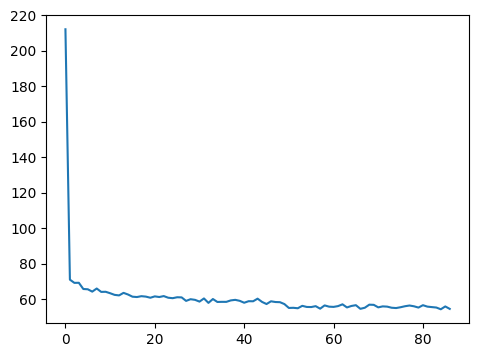

In [13]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mape'], label='Training MAPE')
plt.plot(history.history['val_mape'], label='Validation MAPE')
plt.title('Model MAPE')
plt.xlabel('Epoch')
plt.ylabel('MAPE')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
def plot_predictions(data, title):
    plt.figure(figsize=(12, 6))
    plt.plot(data['actual'], label='Actual Values', color='red')
    plt.plot(data['prediction'], label='Predicted Values', color='blue')
    plt.title(title)
    plt.xlabel('Zeit')
    plt.ylabel('Umsatz')
    plt.legend()
    plt.show()

# Ensure that training_predictions, validation_predictions, training_labels, and validation_labels are numpy arrays
training_predictions = np.array(training_predictions).flatten()
validation_predictions = np.array(validation_predictions).flatten()
training_labels = np.array(training_labels).flatten()
validation_labels = np.array(validation_labels).flatten()

# print the type of the predictions
print(type(training_predictions))
print(type(validation_predictions))

# Create DataFrames with 1-dimensional arrays
data_train = pd.DataFrame({'prediction': training_predictions, 'actual': training_labels})
data_validation = pd.DataFrame({'prediction': validation_predictions, 'actual': validation_labels})

# Plot predictions
plot_predictions(data_train.head(100), 'Predicted and Actual Values for the Training Data')
plot_predictions(data_validation.head(100), 'Predicted and Actual Values for the Validation Data')

NameError: name 'validation_predictions' is not defined

***VORHERSAGE TESTZEITRAUM***

In [16]:
test_predictions = model.predict(test_features)
#print("Predictions for test data:", test_predictions[:5])  # Display first 5 predictions
# Größe des Arrays anzeigen
print("Größe des Arrays (shape):", test_predictions.shape)
test_predictions = pd.DataFrame(test_predictions)
test_predictions

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Größe des Arrays (shape): (355, 1)


,0
0,439.060242
1,458.411804
2,458.411804
3,560.277344
4,525.237061
...,...
350,520.518372
351,604.717834
352,606.074951
353,507.155029


In [17]:
data_test = pd.read_csv("../../../0_DataPreparation/00_data/data_with_lag/Testdaten_with_lag.csv")
data_test = data_test[data_test["Warengruppe_2"] == 1]
data_test

,id,Datum,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,Temp_Very_Cold_current,Temp_Very_Cold_prev,...,zwischen_den_jahren_next,Number_of_ships_scaled_current,Number_of_ships_scaled_prev,Number_of_ships_scaled_next,Cloud_ok_current,Cloud_ok_prev,Cloud_ok_next,Wind_ok_current,Wind_ok_prev,Wind_ok_next
355,1808012,2018-08-01,0,1,0,0,0,0,0,0.0,...,0.0,0.0,0.2,0.0,1,0.0,1.0,1,1.0,1.0
356,1808022,2018-08-02,0,1,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,1,1.0,1.0,1,1.0,1.0
357,1808032,2018-08-03,0,1,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.2,1,1.0,1.0,1,1.0,1.0
358,1808042,2018-08-04,0,1,0,0,0,0,0,0.0,...,0.0,0.2,0.0,0.0,1,1.0,0.0,1,1.0,1.0
359,1808052,2018-08-05,0,1,0,0,0,0,0,0.0,...,0.0,0.0,0.2,0.0,0,1.0,1.0,1,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,1907262,2019-07-26,0,1,0,0,0,0,0,0.0,...,0.0,0.0,0.2,0.6,1,0.0,1.0,1,1.0,0.0
706,1907272,2019-07-27,0,1,0,0,0,0,0,0.0,...,0.0,0.6,0.0,0.4,1,1.0,1.0,0,1.0,1.0
707,1907282,2019-07-28,0,1,0,0,0,0,0,0.0,...,0.0,0.4,0.6,0.2,1,1.0,0.0,1,0.0,1.0
708,1907292,2019-07-29,0,1,0,0,0,0,0,0.0,...,0.0,0.2,0.4,0.2,0,1.0,0.0,1,1.0,1.0


In [18]:
# Erstelle Ziel csv Datei

predictions_df = pd.DataFrame({
    'id': data_test['id'].values,
    'Umsatz': test_predictions[0].values
}).reset_index(drop=True)

# Save to a CSV file
#output_csv_path = "/workspaces/bakery_sales_prediction/3_Model/02_Franz/V3_lag/Umsatzvorhersage_Broetchen_Hochladeformat.csv"

predictions_df.to_csv('Broetchen_Umsatzvorhersage.csv', index=False)
print(f"CSV Datei erstellt")

CSV Datei erstellt
